Finetuning for classification

Preparaing a dataset

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [2]:
import pandas as pd

In [7]:
df = pd.read_csv(data_file_path,sep='\t',header=None,names=['Label','Text'])
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df['Label'].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

In [10]:
def create_balanced_dataset(df):
    num_spam = df[df['Label'] == 'spam'].shape[0]
    ham_subset = df[df['Label']=='ham'].sample(num_spam,random_state=123)
    balanced_df = pd.concat([ham_subset,df[df['Label'] == 'spam']])
    return balanced_df
balanced_df = create_balanced_dataset(df)
balanced_df['Label'].value_counts()

Label
ham     747
spam    747
Name: count, dtype: int64

In [11]:
balanced_df.head()

,Label,Text
4307,ham,Awww dat is sweet! We can think of something t...
4138,ham,Just got to &lt;#&gt;
4831,ham,"The word ""Checkmate"" in chess comes from the P..."
4461,ham,This is wishing you a great day. Moji told me ...
5440,ham,Thank you. do you generally date the brothas?


In [12]:
map_dict = {'ham':0,'spam':1}
balanced_df['Label'] = balanced_df['Label'].map(map_dict)

In [13]:
balanced_df.head()

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?


In [15]:
def random_split(df,train_frac=0.7,valid_frac=0.2):
    df = df.sample(frac=1,random_state=123).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    valid_end = train_end + int(len(df) * valid_frac)
    train_df = df[:train_end]
    valid_df = df[train_end:valid_end]
    test_df = df[valid_end:]
    return train_df, valid_df, test_df

In [16]:
train_df, valid_df, test_df = random_split(balanced_df,0.7,0.1)

train_df.to_csv("train.csv",index=None)
valid_df.to_csv("validation.csv",index=None)
test_df.to_csv("test.csv",index=None)

In [19]:
test_df

,Label,Text
1194,1,85233 FREE>Ringtone!Reply REAL
1195,1,Ur cash-balance is currently 500 pounds - to m...
1196,1,"Thanks for your ringtone order, reference numb..."
1197,0,We live in the next &lt;#&gt; mins
1198,1,1st wk FREE! Gr8 tones str8 2 u each wk. Txt N...
...,...,...
1489,1,FREE2DAY sexy St George's Day pic of Jordan!Tx...
1490,1,Urgent! Please call 09066612661 from your land...
1491,1,For your chance to WIN a FREE Bluetooth Headse...
1492,1,* FREE* POLYPHONIC RINGTONE Text SUPER to 8713...


Creating data loaders

In [20]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.decode([50256]))

<|endoftext|>


In [28]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self,csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data['Text']]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]
        self.encoded_texts = [ encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
                             for encoded_text in self.encoded_texts]

    def __getitem__(self,index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]['Label']
        return(
            torch.tensor(encoded,dtype=torch.long),
            torch.tensor(label,dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        return max(len(encoded_text) for encoded_text in self.encoded_texts)
    
        

In [29]:
train_dataset = SpamDataset('ch06_data/train.csv',max_length=None,tokenizer=tokenizer)

In [30]:
print(train_dataset.max_length)

120


In [31]:
val_dataset = SpamDataset('ch06_data/validation.csv',max_length=train_dataset.max_length,tokenizer=tokenizer)
test_dataset = SpamDataset('ch06_data/test.csv',max_length=train_dataset.max_length,tokenizer=tokenizer)

In [32]:
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size = batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last = True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)
test_loader = DataLoader(
    dataset = test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [33]:
print('Train Loader:')
for input_batch, target_batch in train_loader:
    print(input_batch, target_batch)
    break

print("Input batch dimension:",input_batch.shape)
print("Target batch dimesnion:",target_batch.shape)


Train Loader:
tensor([[   56,    64,   655,  5149,   450,    83,   294,    83,  4519,   492,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
        [   40,  1464,  8537,   351, 

In [34]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} Testing batches")

130 training batches
19 validation batches
38 Testing batches


Intializing a model with pretrained weights

In [35]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [36]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [37]:
model.eval();

In [38]:
from previous_chapters import (generate_text_simple, text_to_token_ids, token_ids_to_text)
text1 = "Every effort moves you"

token_ids = generate_text_simple(model=model, idx=text_to_token_ids(text1,tokenizer), max_new_tokens=15, context_size=BASE_CONFIG['context_length'])
print(token_ids_to_text(token_ids,tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [39]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


Adding Classification head

In [40]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [41]:
for param in model.parameters():
    param.requires_grad = False
# freezing

In [42]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(BASE_CONFIG["emb_dim"],num_classes)

In [43]:
model

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [44]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [45]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:",inputs)
print("Input Dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Input Dimensions: torch.Size([1, 4])


In [46]:
with torch.no_grad():
    outputs = model(inputs)

In [47]:
outputs

tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])

In [48]:
outputs[:,-1,:]

tensor([[-3.5983,  3.9902]])

Calculating the classification loss and accuracy

In [49]:
logits = outputs[:,-1,:]
probas = torch.softmax(logits,dim=-1)
probas

tensor([[5.0598e-04, 9.9949e-01]])

In [51]:
label = torch.argmax(probas)
label

tensor(1)

In [52]:
label = torch.argmax(logits).item()
label

1

In [66]:
def calc_accuracy_loader(data_loader,model,device,num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0,0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches,len(data_loader))

    for i,(input_batch, target_batch) in enumerate(data_loader):
        
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            with torch.no_grad():
                logits = model(input_batch)[:,-1,:]
            predicted_labels = torch.argmax(logits,dim=-1)
            num_examples+=predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)


0.4625

In [67]:
train_accuracy = calc_accuracy_loader(train_loader,model,device,num_batches=None)
train_accuracy

0.49423076923076925

In [68]:
val_accuracy = calc_accuracy_loader(val_loader,model,device,num_batches=None)
val_accuracy

0.5302013422818792

In [69]:
 def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [70]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [71]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.576
Validation loss: 2.583
Test loss: 2.322


Finetuning the model on supervised data

In [80]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [81]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader,model,device,num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader,model,device,num_batches=eval_iter)
    model.train()
    return train_loss,val_loss

In [82]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-5,weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs,
                            eval_freq=50, eval_iter=5
)
end_time = time.time()
execution_time_minutes = (end_time-start_time)/60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.617, Val loss 1.795
Ep 1 (Step 000050): Train loss 0.614, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.512, Val loss 0.548
Training accuracy: 72.50% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.572, Val loss 0.486
Ep 2 (Step 000200): Train loss 0.417, Val loss 0.391
Ep 2 (Step 000250): Train loss 0.402, Val loss 0.342
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.244, Val loss 0.195
Ep 3 (Step 000350): Train loss 0.229, Val loss 0.105
Training accuracy: 95.00% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.047, Val loss 0.094
Ep 4 (Step 000450): Train loss 0.099, Val loss 0.072
Ep 4 (Step 000500): Train loss 0.177, Val loss 0.077
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.183, Val loss 0.089
Ep 5 (Step 000600): Train loss 0.059, Val loss 0.049
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 0.43 min

In [83]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

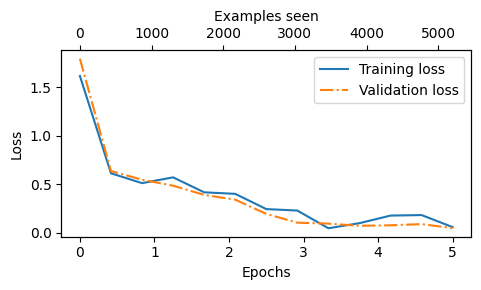

In [84]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

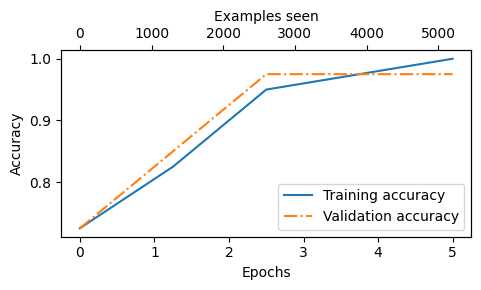

In [85]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [86]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.88%
Validation accuracy: 97.99%
Test accuracy: 96.67%


Using the LLM as a spam classifier

In [92]:
def classify_text(text, model, tokenizer, device, max_length = None,pad_token_id=50256):
    inputs_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    inputs_ids = inputs_ids[:min(max_length,supported_context_length)]
    inputs_ids += [pad_token_id] * (max_length - len(inputs_ids))
    inputs_ids = torch.tensor(inputs_ids,device = device).unsqueeze(0)
    with torch.no_grad():
        logits = model(inputs_ids)[:,-1,:]
    predicted_label = torch.argmax(logits,dim=-1).item()
    return "spam" if predicted_label == 1 else "not spam"
    

In [93]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_text(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [95]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_text(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [96]:
torch.save(model.state_dict(),"text_classifier.pth")